In [83]:
# default_exp core

# shot_chart

> Plots the NBA shot_charts and shot distribution for players, teams and the whole league.

In [84]:
#hide
from nbdev.showdoc import *

In [85]:
# export
from pathlib import Path
import os
import yaml
import pandas as pd
import requests
import tarfile
from fastprogress.fastprogress import master_bar, progress_bar
import matplotlib.pyplot as plt
from typing import Sequence, Tuple, TypeVar, Union
from typing import Any, AnyStr, Callable, Collection, Dict, Hashable, Iterator, List, Mapping, NewType, Optional
import boto3
import hashlib
import shutil
import numpy as np
import inspect

In [86]:
# export
class Config:
    config_path = Path(os.getenv('SHOTCHART_HOME', '~/.shot_chart')).expanduser()
    config_file = config_path/'config.yml'

    def __init__(self):
        self.config_path.mkdir(parents=True, exist_ok=True)
        if not self.config_file.exists(): self.create_config()
        self.d = self.load_config()

    def __getitem__(self,k):
        k = k.lower()
        if k not in self.d: k = k+'_path'
        if k in ["my_dpi","fig_height","fig_width"]:
            return self.d[k]
        return Path(self.d[k])

    def __getattr__(self,k):
        if k=='d': raise AttributeError
        return self[k]

    def __setitem__(self,k,v): self.d[k] = str(v)
    def __contains__(self,k): return k in self.d

    def load_config(self):
        with open(self.config_file, 'r') as f:
            config = yaml.safe_load(f)
            if 'version' in config and config['version'] == 1: return config
        self.create_config()
        return self.load_config()

    def create_config(self):
        F = plt.gcf()
        # Now check everything with the defaults:
        DPI = F.get_dpi()
        config = {'data_path':    str(self.config_path/'data'),
                  'archive_path':    str(self.config_path/'archive'),
                  'version':      1,
                  'my_dpi': DPI,
                  'fig_height': 472,
                  'fig_width': 500
                 }
        self.save_file(config)

    def save(self): self.save_file(self.d)
    def save_file(self, config):
        with self.config_file.open('w') as f: yaml.dump(config, f, default_flow_style=False)

In [87]:
config = Config()

## URLs -

In [93]:
# export
class URLs():
    "Global constants for dataset and model URLs."
    LOCAL_PATH = Path.cwd()
    S3 = 'https://nba-shot-charts.s3.amazonaws.com/'

    SHOTS_2000    = f'{S3}shots-2000.tgz'
    SHOTS_2001    = f'{S3}shots-2001.tgz'
    SHOTS_2002    = f'{S3}shots-2002.tgz'
    SHOTS_2003    = f'{S3}shots-2003.tgz'
    SHOTS_2004    = f'{S3}shots-2004.tgz'
    SHOTS_2005    = f'{S3}shots-2005.tgz'
    SHOTS_2006    = f'{S3}shots-2006.tgz'
    SHOTS_2007    = f'{S3}shots-2007.tgz'
    SHOTS_2008    = f'{S3}shots-2008.tgz'
    SHOTS_2009    = f'{S3}shots-2009.tgz'
    SHOTS_2010    = f'{S3}shots-2010.tgz'
    SHOTS_2011    = f'{S3}shots-2011.tgz'
    SHOTS_2012    = f'{S3}shots-2012.tgz'
    SHOTS_2013    = f'{S3}shots-2013.tgz'
    SHOTS_2014    = f'{S3}shots-2014.tgz'
    SHOTS_2015    = f'{S3}shots-2015.tgz'
    SHOTS_2016    = f'{S3}shots-2016.tgz'
    SHOTS_2017    = f'{S3}shots-2017.tgz'
    SHOTS_2018    = f'{S3}shots-2018.tgz'
    SHOTS_2019    = f'{S3}shots-2019.tgz'
    SHOTS_2020    = f'{S3}shots-2020.tgz'
    SHOTS_2021    = f'{S3}shots-2021.tgz'
    SHOTS_2022    = f'{S3}shots-2022.tgz'
    SHOTS_2023    = f'{S3}shots-2023.tgz'
    SHOTS_2024    = f'{S3}shots-2024.tgz'
    SHOTS_2025    = f'{S3}shots-2025.tgz'

    def path(url, c_key='archive'):
        fname = url.split('/')[-1]
        local_path = URLs.LOCAL_PATH/('data' if c_key=='data' else 'archive')/fname
        if local_path.exists(): return local_path
        return Config()[c_key]/fname

## Downloading

In [94]:
# export
def download_url(url, dest, overwrite=False, pbar=None, show_progress=True, chunk_size=1024*1024,
                 timeout=4, retries=5):
    "Download `url` to `dest` unless it exists and not `overwrite`"
    if os.path.exists(dest) and not overwrite: return

    s = requests.Session()
    s.mount('http://',requests.adapters.HTTPAdapter(max_retries=retries))
    # additional line to identify as a firefox browser, see fastai/#2438
    s.headers.update({'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'})
    u = s.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: show_progress = False

    with open(dest, 'wb') as f:
        nbytes = 0
        if show_progress: pbar = progress_bar(range(file_size), leave=False, parent=pbar)
        try:
            if show_progress: pbar.update(0)
            for chunk in u.iter_content(chunk_size=chunk_size):
                nbytes += len(chunk)
                if show_progress: pbar.update(nbytes)
                f.write(chunk)
        except requests.exceptions.ConnectionError as e:
            fname = url.split('/')[-1]
            data_dir = dest.parent
            print(f'\n Download of {url} has failed after {retries} retries\n'
                  f' Fix the download manually:\n'
                  f'$ mkdir -p {data_dir}\n'
                  f'$ cd {data_dir}\n'
                  f'$ wget -c {url}\n'
                  f'$ tar xf {fname}\n'
                  f' And re-run your code once the download is successful\n')

In [95]:
# export
def download_data(url, fname=None, c_key='archive', force_download=False):
    "Download `url` to `fname`."
    fname = Path(fname or URLs.path(url, c_key=c_key))
    fname.parent.mkdir(parents=True, exist_ok=True)
    if not fname.exists() or force_download: download_url(url, fname, overwrite=force_download)
    return fname

### Extract

In [96]:
#export
def file_extract(fname, dest='.'):
    "Extract `fname` to `dest` using `tarfile` or `zipfile"
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

`file_extract` is used by default in `untar_data` to decompress the downloaded file.

In [97]:
#export 
def _get_check(url):
    s3 = boto3.client('s3')
    s3_resp = s3.head_object(Bucket=URLs.S3.split(".")[0].split("//")[1],Key=url.split("/")[-1])
    ETag = s3_resp['ETag'].strip('"')
    # Open,close, read file and calculate MD5 on its contents 
    with open(Path(URLs.path(url)),"rb") as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        md5_returned = hashlib.md5(data).hexdigest()
    return ETag != md5_returned

In [98]:
URLs.path(URLs.SHOTS_2024)

Path('/Users/ccalderon/.shot_chart/archive/shots-2024.tgz')

In [99]:
#export
def untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=file_extract):
    "Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`."
    default_dest = URLs.path(url, c_key=c_key).with_suffix('.csv')
    dest = default_dest if dest is None else Path(dest)/default_dest.name
    fname = Path(fname or URLs.path(url))
    if fname.exists() and _get_check(url):
        print("A new version of this dataset is available, downloading...")
        force_download = True
    if force_download:
        if fname.exists(): os.remove(fname)
        if dest.exists(): os.remove(dest)
    if not dest.exists():
        fname = download_data(url, fname=fname, c_key=c_key)
        extract_func(fname, dest.parent)
    return dest

In [116]:
#export
def make_df(path):
    "Creates a pandas dataframe from `path`"
    return pd.read_csv(path)

In [119]:
shots_2020 = make_df(untar_data(URLs.SHOTS_2021))

/var/folders/c5/vksplvp52f5d7k58vwqjlx4m0000gn/T/ipykernel_90651/4088188687.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)


In [120]:
#hide
shots_2020.head()

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score
0,84,202110190MIL,2021,10,19,Milwaukee,Brooklyn,243px,75px,"1st quarter, 11:42.0 remaining<br>Grayson Alle...",11:42.0,1,Grayson Allen,missed,3-pointer,27ft,Milwaukee,0,0
1,85,202110190MIL,2021,10,19,Milwaukee,Brooklyn,296px,240px,"1st quarter, 11:13.0 remaining<br>Giannis Ante...",11:13.0,1,Giannis Antetokounmpo,missed,3-pointer,26ft,Milwaukee,0,0
2,86,202110190MIL,2021,10,19,Milwaukee,Brooklyn,180px,244px,"1st quarter, 11:01.0 remaining<br>Giannis Ante...",11:01.0,1,Giannis Antetokounmpo,missed,2-pointer,15ft,Milwaukee,0,0
3,0,202110190MIL,2021,10,19,Milwaukee,Brooklyn,36px,242px,"1st quarter, 10:47.0 remaining<br>Nic Claxton ...",10:47.0,1,Nic Claxton,made,2-pointer,0ft,Brooklyn,0,2
4,87,202110190MIL,2021,10,19,Milwaukee,Brooklyn,137px,254px,"1st quarter, 10:31.0 remaining<br>Giannis Ante...",10:31.0,1,Giannis Antetokounmpo,missed,2-pointer,11ft,Milwaukee,0,2


### Using the `delegate` function from https://www.fast.ai/2019/08/06/delegation/

In [121]:
#export
def delegates(to=None, keep=False):
    "Decorator: replace `**kwargs` in signature with params from `to`"
    def _f(f):
        if to is None: to_f,from_f = f.__base__.__init__,f.__init__
        else:          to_f,from_f = to,f
        sig = inspect.signature(from_f)
        sigd = dict(sig.parameters)
        k = sigd.pop('kwargs')
        s2 = {k:v for k,v in inspect.signature(to_f).parameters.items()
              if v.default != inspect.Parameter.empty and k not in sigd}
        sigd.update(s2)
        if keep: sigd['kwargs'] = k
        from_f.__signature__ = sig.replace(parameters=sigd.values())
        return f
    return _f

## Creating a class - Shots

In [168]:
#export
class Shots:
    "Plots shot chart and most/least effective shots using `plot_shots` and `plot_effective`"
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.__X_MODIFIER = 10
        self.__Y_MODIFIER = 454
        
    
    @property
    def teams(self):
        return self.dataframe['team'].drop_duplicates()
    
    @property
    def players(self):
        return self.dataframe['shots_by'].drop_duplicates()

    @property
    def fg_pct(self):
        return self.__calculate_metric(self.dataframe,"fg")
    
    @property
    def efg_pct(self):
        return self.__calculate_metric(self.dataframe,"efg")
    
    def __calculate_metric(self, dataframe, metric="efg"):
        if len(dataframe)==0:
            return 0
        if metric == "fg":
            return round(len(dataframe.loc[dataframe['outcome']=='made'])/len(dataframe),2)
        else:
            return round( (len(dataframe.loc[dataframe['outcome']=='made']) + 0.5 *len(dataframe.loc[(dataframe['outcome']=='made') & (dataframe['attempt']=='3-pointer')]))/len(dataframe),2)

    def __plot_shot_chart(self, dataframe, metric:str="efg",attempt:str="all", distance_limit:Union[int,tuple]=29):
        if type(distance_limit) == int:
            distances = [str(x)+"ft" for x in range(distance_limit+1)]
        else:
            distances = [str(x)+"ft" for x in range(distance_limit[0],distance_limit[1]+1)]
        plt.figure(figsize=(2 * Config().fig_height/Config().my_dpi, Config().fig_width/Config().my_dpi), dpi=Config().my_dpi)
        ax = plt.subplot(1, 2, 1)
        plt.title("Shot chart")
        img = PIL.Image.open(urllib.request.urlopen("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png"))
        implot = plt.imshow(img, extent=[0,500,0,472])
        if attempt == "2-pointer":
                shots_df = dataframe.loc[(dataframe["attempt"]=="2-pointer") & (dataframe["distance"].isin(distances))]
        elif attempt == "3-pointer":
                shots_df = dataframe.loc[(dataframe["attempt"]=="3-pointer") & (dataframe["distance"].isin(distances))]
        else:
            shots_df = dataframe
        if len(shots_df) > 200:
            ys = shots_df['x'].apply(lambda x: x.split("px")[0]).to_list()
            ys = [self.__Y_MODIFIER - int(x) for x in ys]
            xs = shots_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
            xs = [x + self.__X_MODIFIER for x in xs]
            mycmap = plt.cm.Reds
            mycmap._init()
            mycmap._lut[:,-1] = np.linspace(0, 0.8, 256+3)
            plt.hexbin(xs, ys, gridsize=(50,47), bins='log',cmap=mycmap)
    #         cb = plt.colorbar(label='count in bin')
        else:
            made_df = shots_df.loc[shots_df['outcome']=="made"]
            missed_df = shots_df.loc[shots_df['outcome']=="missed"]
            ys = made_df['x'].apply(lambda x: x.split("px")[0]).to_list()
            ys = [self.__Y_MODIFIER - int(x) for x in ys]
            xs = made_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
            xs = [x + self.__X_MODIFIER for x in xs]
#             if most_or_least == 'most':
            plt.scatter(xs, ys,c='g',marker='o',s=10, alpha=1)
#             else:
#                 plt.scatter(xs, ys,c='g',marker='o',s=10, alpha=0.2)
            ys = missed_df['x'].apply(lambda x: x.split("px")[0]).to_list()
            ys = [self.__Y_MODIFIER - int(x) for x in ys]
            xs = missed_df['y'].apply(lambda x: int(x.split("px")[0])).to_list()
            xs = [x + self.__X_MODIFIER for x in xs]
#             if most_or_least == 'least':
#                 plt.scatter(xs, ys,c='g',marker='o',s=10, alpha=1)
#             else:
            plt.scatter(xs, ys,c='orange',marker='x',s=10, alpha=0.5)
#             plt.scatter(xs, ys,c='orange',marker='x',s=10)
        return
    
    def __plot_hist_volume(self, dataframe, fg_pct:float, efg_pct:float, most_or_least:str=None, final_distance:str=None, final_attempt:str=None,made:bool=True,missed:bool=True):
        if made:
            ax = plt.subplot(1, 2, 2)
            plt.title("Shot distribution - all distances")
            distances_all_shots = dataframe['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
            make_shots = dataframe.loc[dataframe['outcome']=='made']['distance'].apply(lambda x: int(x.split('ft')[0])).to_list()
            shots_to_plot = [make_shots,distances_all_shots]
            plt.hist(shots_to_plot, bins = range( 0, max(distances_all_shots)+1, 1), align="left",stacked=True, label=['made','all'], color=['green', '#ff7f0e'])
            plt.legend(loc="upper center")
            if most_or_least and final_distance and final_attempt:
                ax.text(30 + 12, 1, most_or_least+" effective shot: "+str(final_distance)+"\n Attempt: "+final_attempt+"\n\nMetrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
            else:
                ax.text(30 + 12, 1, "Metrics:\n FG%: "+str(fg_pct)+"\n eFG%: "+str(efg_pct), bbox=dict(facecolor='red', alpha=0.5))
        return
    
    def list_game_ids(self,year,month,day):
        "Lists unique game ids in `dataframe` for a given date"
        return self.dataframe.loc[(self.dataframe['year']==year) & (self.dataframe['month']==month) & (self.dataframe['day']==day)][['game_id','winner','loser']].drop_duplicates()
    
    @delegates(__plot_shot_chart)
    def plot_shots(self,date_range:Union[str,tuple,int]="all",**kwargs):
        "Plots the shot chart for a given `date_range` including `made`, `missed` and `attempt` shots within `distances`"
        #use kwargs
        if date_range == "all":
            shots_df = self.dataframe
        elif type(date_range) == str:
            shots_df = self.dataframe.loc[self.dataframe['game_id']==date_range]
        elif type(date_range) == int:
            #means month
            shots_df = self.dataframe.loc[self.dataframe["month"]==date_range]
        else:
            copy_df = self.dataframe.copy()
            copy_df['Timestamp'] = pd.to_datetime(copy_df.loc[:][['year','month','day']])
            # Create a DatetimeIndex and assign it to the dataframe.
            breakpoint()
            if not copy_df.index.is_monotonic_increasing:
                copy_df = copy_df.sort_index()
            copy_df.index = pd.DatetimeIndex(copy_df.Timestamp)
            shots_df = copy_df.loc[str(str(date_range[0][0])+"-"+str(date_range[0][1])+"-"+str(date_range[0][2])):str(str(date_range[1][0])+"-"+str(date_range[1][1])+"-"+str(date_range[1][2]))]
        self.__plot_shot_chart(shots_df, **kwargs)
        self.__plot_hist_volume(shots_df, self.__calculate_metric(self.dataframe, "fg"), self.__calculate_metric(self.dataframe, "efg"))
        plt.show()
    
    @delegates(__plot_shot_chart)
    def plot_effective(self, most_or_least="most",metric:str="efg", min_shots:Union[str,int]="none", exclude:Union[str,List["str"]]="none", **kwargs):
        "Plots the shot chart based on `most_or_least` considering a given `metric` for `date_range` including `made`, `missed` and `attempt` shots within `distances`. You can optionally `exclude` some shots. The `min_shots` option lets you filter based on a minimum ammount of shots taken per distance, auto == uniform distribution [0ft,29ft] as tracked by https://stats.nba.com/players/shooting/?sort=25-29%20ft.%20FGA&dir=1&Season=2019-20&SeasonType=Regular%20Season&CF=PLAYER_NAME*E*"
        distances = ["0ft","1ft","2ft","3ft","4ft","5ft","6ft","7ft","8ft","9ft","10ft","11ft","12ft","13ft","14ft","15ft","16ft","17ft","18ft","19ft","20ft","21ft","22ft","23ft","24ft","25ft","26ft","27ft","28ft"]
        distances = set(distances).intersection(set(self.dataframe['distance'].drop_duplicates().to_list()))
        if type(exclude) == list:
            distances = list(set(distances) - set(exclude))
        #if auto, use uniform distro
        if min_shots == "none":
            new_df = self.dataframe
        elif min_shots == "auto":
            min_value = round(len(self.dataframe)/30,0) # [0ft, 29ft]
            new_df = pd.DataFrame(columns = self.dataframe.columns)
            for distance in distances:
                if len(self.dataframe.loc[self.dataframe['distance']==distance]) >= min_value:
                    new_df = new_df.append(self.dataframe.loc[self.dataframe['distance']==distance])
        else:
            min_value = min_shots
            new_df = pd.DataFrame(columns = self.dataframe.columns)
            for distance in distances:
                if len(self.dataframe.loc[self.dataframe['distance']==distance]) >= min_value:
                    new_df = new_df.append(self.dataframe.loc[self.dataframe['distance']==distance])
        if most_or_least == "most":
            max_fg = -1
            max_efg = -1
            final_distance = ""
            for attempt in ["2-pointer", "3-pointer"]:
                for distance in distances:
                    player_df = new_df.loc[(new_df["distance"]==distance) & (new_df["attempt"]==attempt)]
                    if len(player_df) == 0:
                        continue
                    fg_pct = self.__calculate_metric(player_df, "fg")
                    efg_pct = self.__calculate_metric(player_df, "efg")
                    if metric == "fg":
                        if fg_pct > max_fg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
                    else:
                        if efg_pct > max_efg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
        else:
            max_fg = 101
            max_efg = 101
            final_distance = ""
            for attempt in ["2-pointer", "3-pointer"]:
                for distance in distances:
                    player_df = new_df.loc[(new_df["distance"]==distance) & (new_df["attempt"]==attempt)]
                    if len(player_df) == 0:
                        continue
                    fg_pct = self.__calculate_metric(player_df, "fg")
                    efg_pct = self.__calculate_metric(player_df, "efg")
                    if metric == "fg":
                        if fg_pct < max_fg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
                    else:
                        if efg_pct < max_efg:
                            max_fg = fg_pct
                            max_efg = efg_pct
                            final_distance = distance
                            final_attempt = attempt
        player_df = new_df.loc[(new_df["distance"]==final_distance) & (new_df["attempt"] == final_attempt)]
        self.__plot_shot_chart(player_df, **kwargs)
        all_shots = self.dataframe
        self.__plot_hist_volume(all_shots, fg_pct=max_fg, efg_pct=max_efg, most_or_least=most_or_least, final_distance=final_distance, final_attempt=final_attempt)
        plt.show()

In [169]:
mycmap = plt.cm.Reds
mycmap._init()
mycmap._lut[:,-1] = np.linspace(0, 0.8, 259)

In [170]:
shots = Shots(shots_2020)

In [ ]:
shots.players

0                 Grayson Allen
1         Giannis Antetokounmpo
3                   Nic Claxton
6                  James Harden
7                   Brook Lopez
                  ...          
203149         Gabriel Lundberg
212992                Gabe York
214228               Feron Hunt
215071                Matt Ryan
216187         Arnoldas Kulboka
Name: shots_by, Length: 596, dtype: object

In [172]:
viridis = plt.cm.get_cmap('viridis', 12)


/var/folders/c5/vksplvp52f5d7k58vwqjlx4m0000gn/T/ipykernel_90651/1129894437.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 12)


In [173]:
print('viridis.colors', viridis.colors)

viridis.colors [[0.267004 0.004874 0.329415 1.      ]
 [0.283072 0.130895 0.449241 1.      ]
 [0.262138 0.242286 0.520837 1.      ]
 [0.220057 0.343307 0.549413 1.      ]
 [0.177423 0.437527 0.557565 1.      ]
 [0.143343 0.522773 0.556295 1.      ]
 [0.119512 0.607464 0.540218 1.      ]
 [0.166383 0.690856 0.496502 1.      ]
 [0.319809 0.770914 0.411152 1.      ]
 [0.525776 0.833491 0.288127 1.      ]
 [0.762373 0.876424 0.137064 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


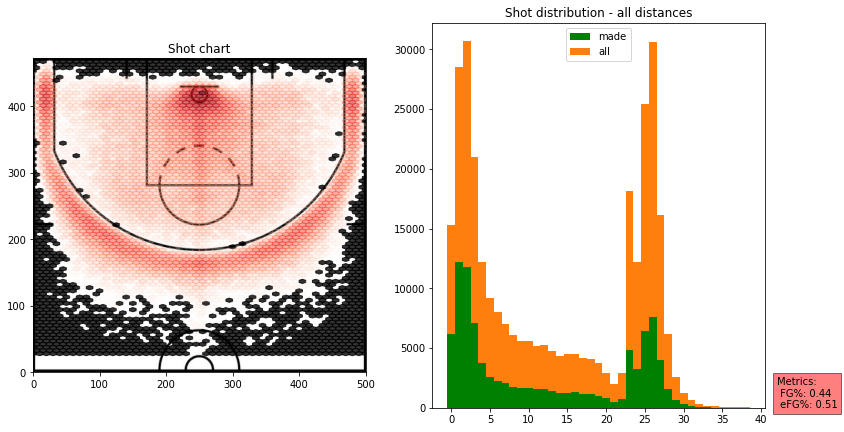

In [174]:
shots.plot_shots()

In [167]:
shots.plot_shots(date_range=((2021,4,1), (2021,4,18)))

KeyError: 'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


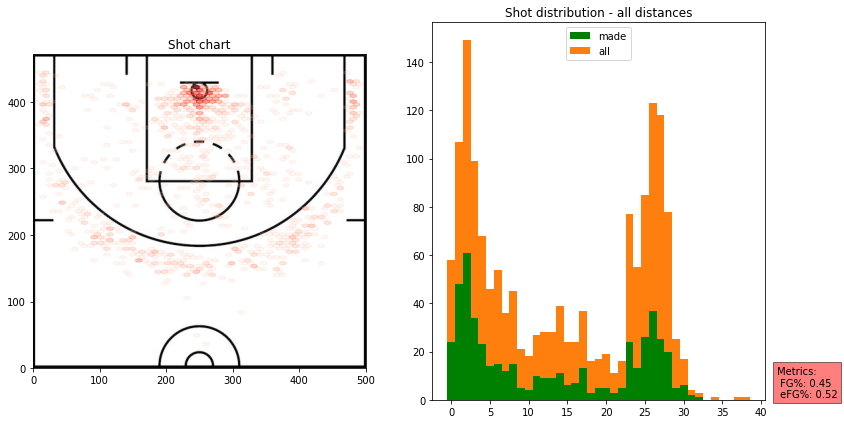

In [29]:
shots.plot_shots(date_range=((2021,4,17), (2021,4,18)))

In [33]:
shots.list_game_ids(2021, 4, 17)

,game_id,winner,loser
144708,202104170WAS,Washington,Detroit
144885,202104170PHO,San Antonio,Phoenix
145064,202104170MIL,Memphis,Milwaukee
145248,202104170BOS,Boston,Golden State
145421,202104170LAL,LA Lakers,Utah
145613,202104170CHI,Chicago,Cleveland


<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


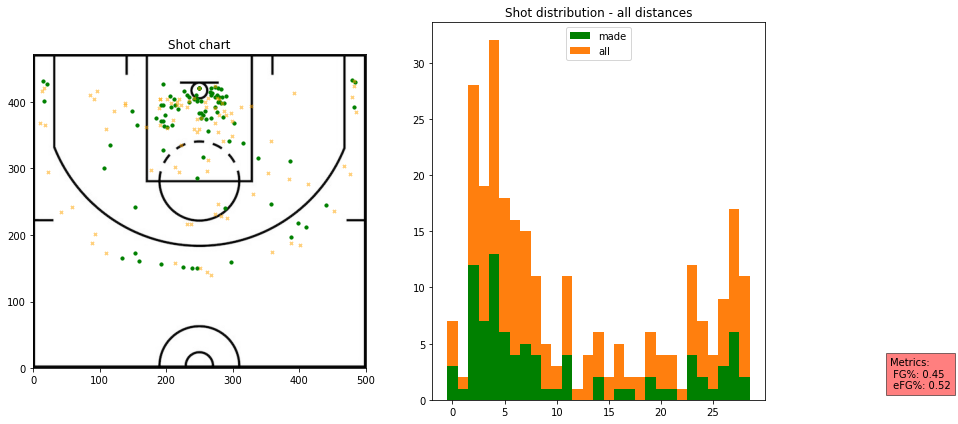

In [34]:
shots.plot_shots(date_range="202104170WAS")

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


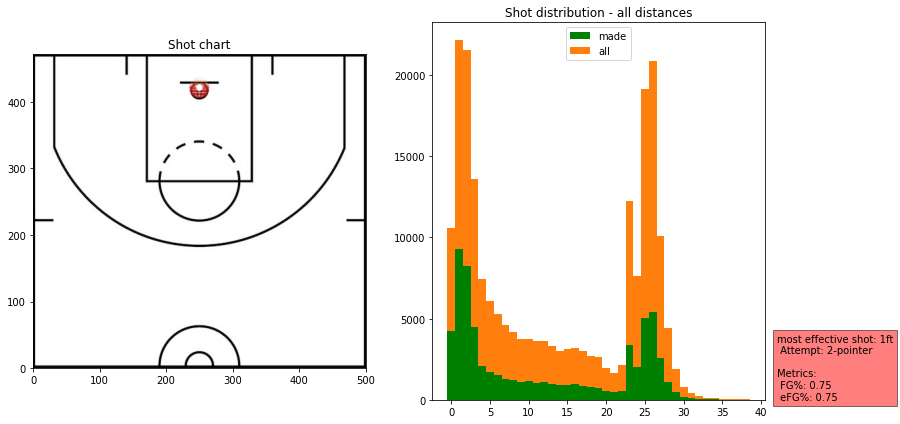

In [35]:
shots.plot_effective(most_or_least="most", metric="efg")

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


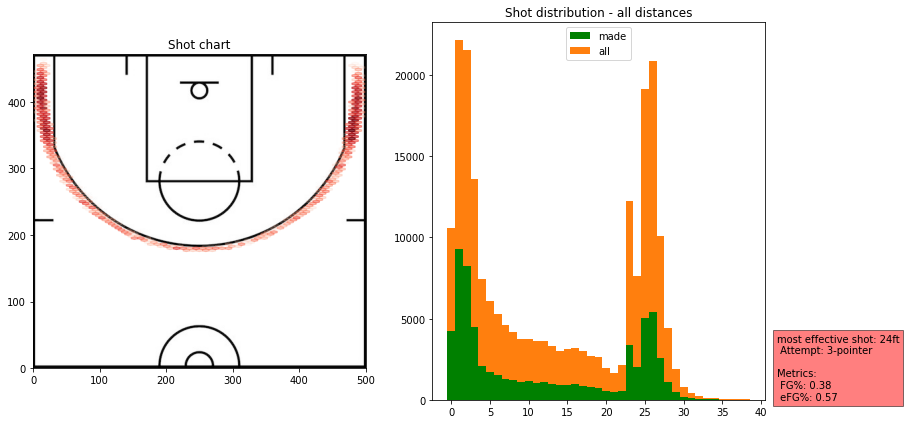

In [36]:
shots.plot_effective(most_or_least="most", metric="efg", exclude=['0ft','1ft','2ft','23ft'])

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


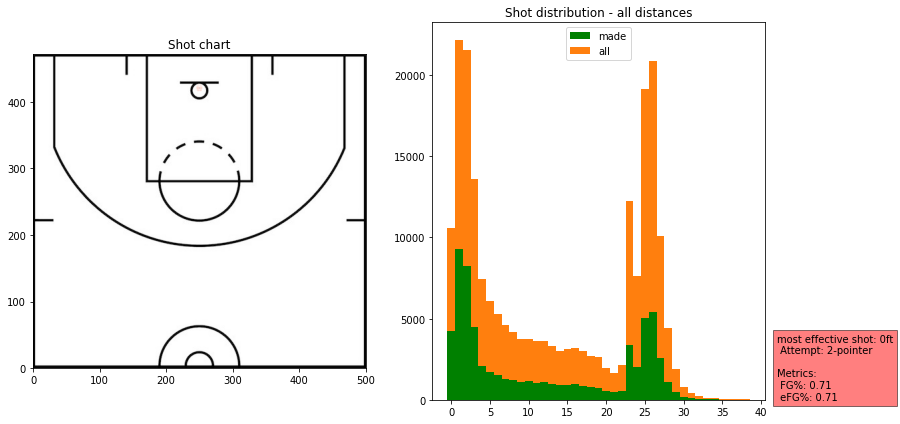

In [37]:
shots.plot_effective(most_or_least="most", min_shots="auto",exclude=['1ft','2ft','23ft','24ft','25ft','26ft','27ft'])

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


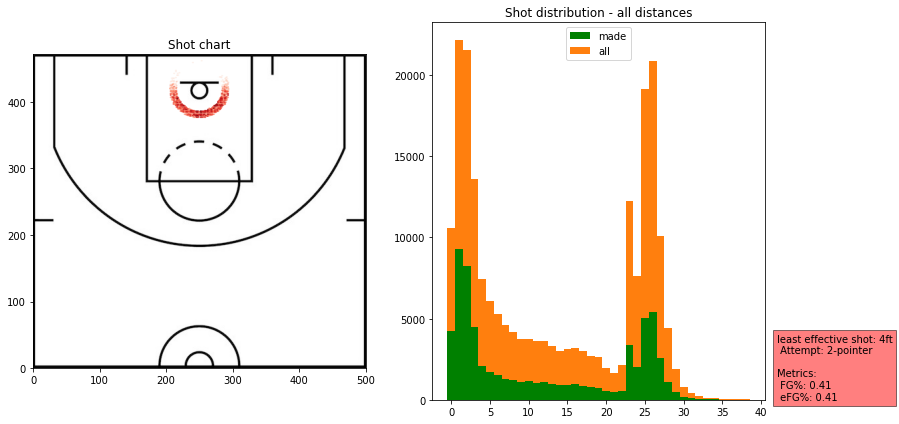

In [38]:
shots.plot_effective(most_or_least="least", min_shots='auto',exclude=['24ft','23ft'])

## List teams

In [39]:
#export
def list_teams(dataframe):
    "Lists all the teams in `dataframe`"
    return dataframe['team'].drop_duplicates()

In [40]:
print(list_teams(shots_2020))

0          LA Lakers
1        LA Clippers
173         Brooklyn
174     Golden State
362          Chicago
363       Washington
533           Denver
534       Sacramento
708      New Orleans
709          Phoenix
869          Toronto
870     Philadelphia
1043        Oklahoma
1045         Orlando
1226       Milwaukee
1229           Miami
1397            Utah
1569        Portland
1750         Houston
1921         Memphis
2119         Atlanta
2120         Detroit
2652          Dallas
2817       Minnesota
2998       Cleveland
3161     San Antonio
3707       Charlotte
4060         Indiana
5863        New York
5865          Boston
Name: team, dtype: object


## List unique game ids

In [41]:
#export
def list_game_ids(dataframe,year,month,day):
    "Lists unique game ids in `dataframe` for a given date"
    return dataframe.loc[(dataframe['year']==year) & (dataframe['month']==month) & (dataframe['day']==day)][['game_id','winner','loser']].drop_duplicates()
    

In [42]:
list_game_ids(shots_2020,2021,4,17)

,game_id,winner,loser
144708,202104170WAS,Washington,Detroit
144885,202104170PHO,San Antonio,Phoenix
145064,202104170MIL,Memphis,Milwaukee
145248,202104170BOS,Boston,Golden State
145421,202104170LAL,LA Lakers,Utah
145613,202104170CHI,Chicago,Cleveland


## Inheriting from Shots to create TeamShots

In [43]:
#export
class TeamShots(Shots):
    "Team shots"
    def __init__(self, dataframe, team):
        dataframe = dataframe.loc[dataframe['team']==team].copy()
        self.team = team
        super().__init__(dataframe)

In [45]:
team_shots = TeamShots(shots_2020,"Portland")

In [46]:
team_shots.team

'Portland'

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


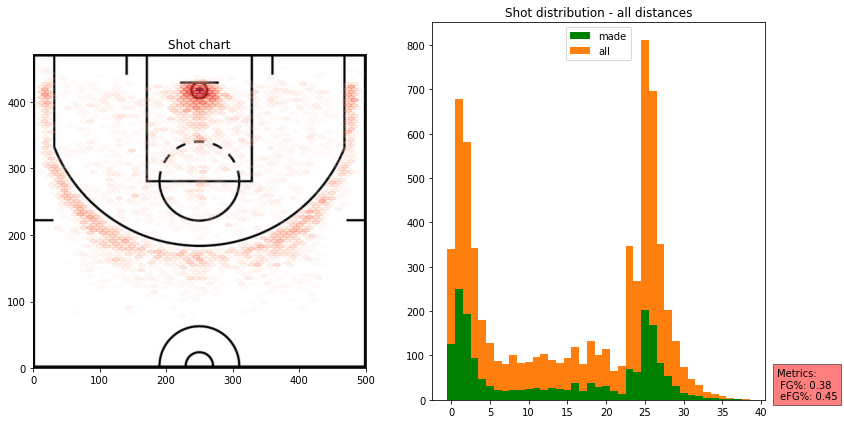

In [47]:
team_shots.plot_shots()

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


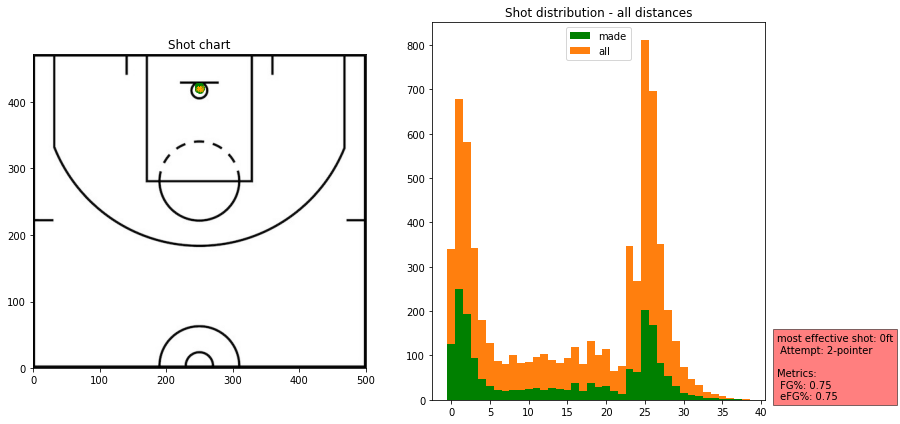

In [48]:
team_shots.plot_effective()

In [50]:
team_shots.dataframe.loc[(team_shots.dataframe['distance']=='24ft') & (team_shots.dataframe['attempt']=='2-pointer')]

,Unnamed: 0,game_id,year,month,day,winner,loser,x,y,play,time_remaining,quarter,shots_by,outcome,attempt,distance,team,winner_score,loser_score


<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


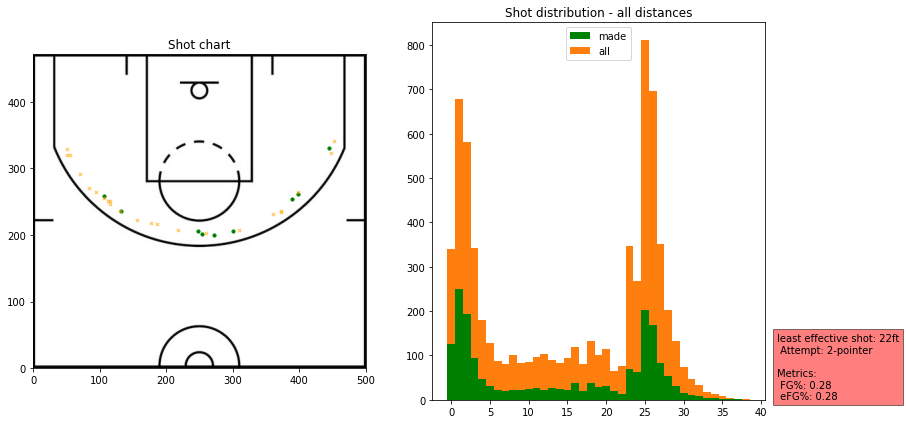

In [51]:
team_shots.plot_effective(most_or_least="least")

In [53]:
team_shots = TeamShots(shots_2020,"Houston")

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


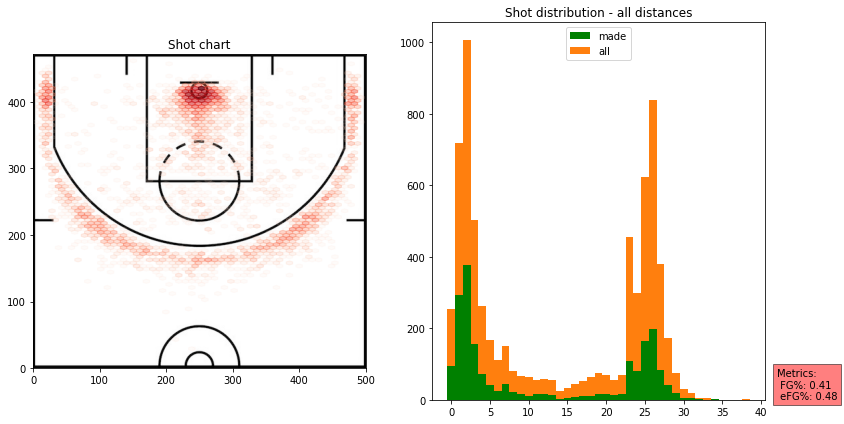

In [54]:
team_shots.plot_shots()

<ipython-input-17-a092ce7bf15d>:118: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  shots_df = copy_df.loc[str(str(date_range[0][0])+"-"+str(date_range[0][1])+"-"+str(date_range[0][2])):str(str(date_range[1][0])+"-"+str(date_range[1][1])+"-"+str(date_range[1][2]))]
<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


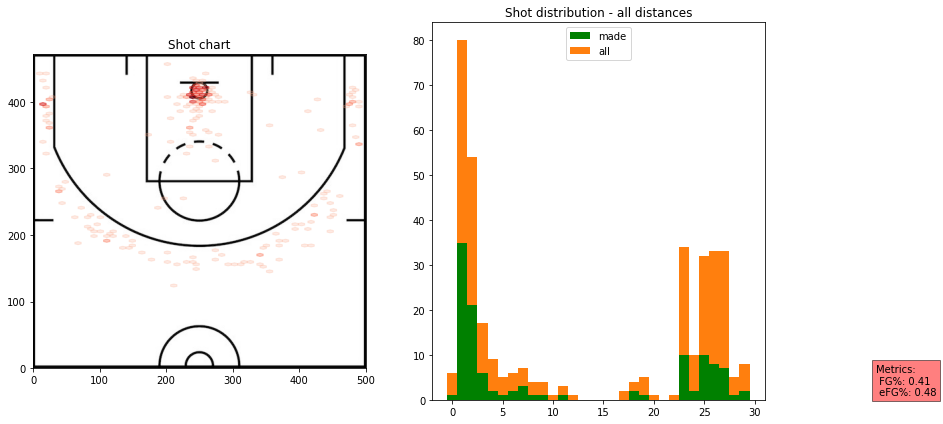

In [55]:
team_shots.plot_shots(date_range=((2021,1,3), (2021,1,8)))

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


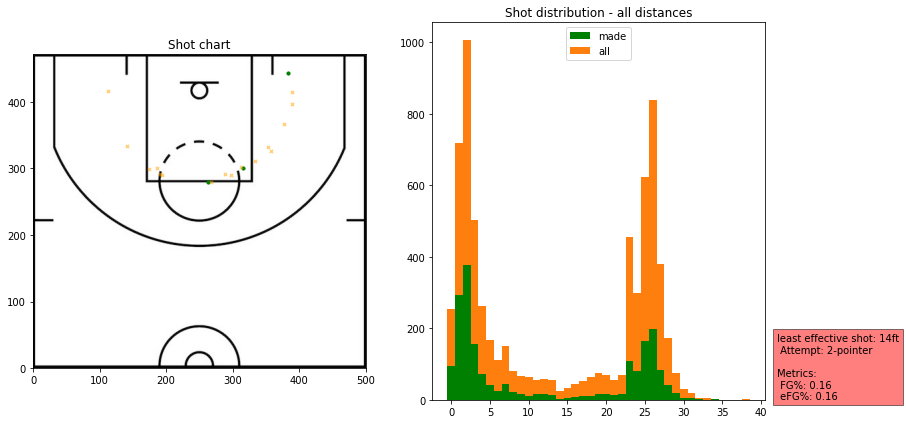

In [56]:
team_shots.plot_effective("least")

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


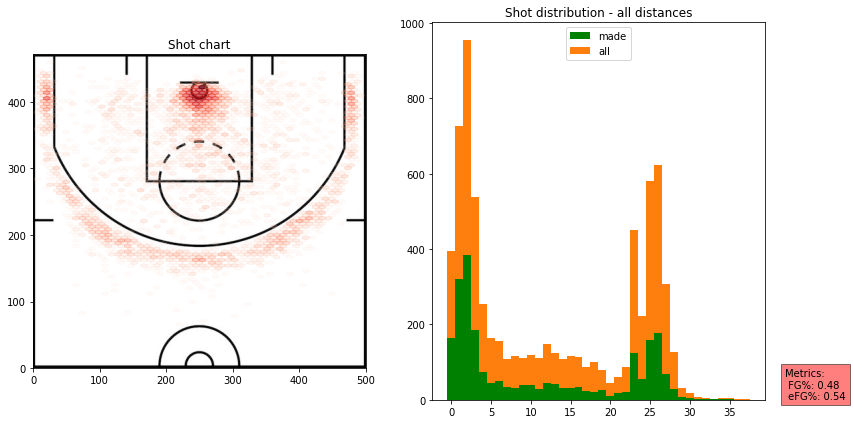

In [57]:
team_shots = TeamShots(shots_2020,"LA Lakers")
team_shots.plot_shots()

## List players who took shots for a team

In [58]:
#export
def list_team_players(dataframe, team):
    "Lists the players in `dataframe` who took shots for a `team`"
    return dataframe.loc[dataframe['team']==team].groupby('shots_by').shots_by.count().reset_index(name='count').sort_values(['count'], ascending=False)

In [60]:
list_team_players(shots_2020,'LA Lakers')

,shots_by,count
12,LeBron James,755
6,Dennis Schröder,651
11,Kyle Kuzma,611
15,Montrezl Harrell,526
17,Talen Horton-Tucker,393
9,Kentavious Caldwell-Pope,389
3,Anthony Davis,383
14,Markieff Morris,310
0,Alex Caruso,225
18,Wesley Matthews,207


## Inheriting from Shots to create PlayerShots

In [61]:
#export
class PlayerShots(Shots):
    "Player shots"
    def __init__(self, dataframe, player):
        self.team_total_shots = len(dataframe.loc[dataframe['team'] == dataframe.loc[dataframe['shots_by']==player]['team'].to_list()[0]])
        dataframe = dataframe.loc[dataframe['shots_by']==player].copy()
        self.player = player
        super().__init__(dataframe)
    

In [62]:
player_shots = PlayerShots(shots_2020,"Kevin Durant")

In [63]:
player_shots.fg_pct

0.54

In [64]:
player_shots.efg_pct

0.61

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


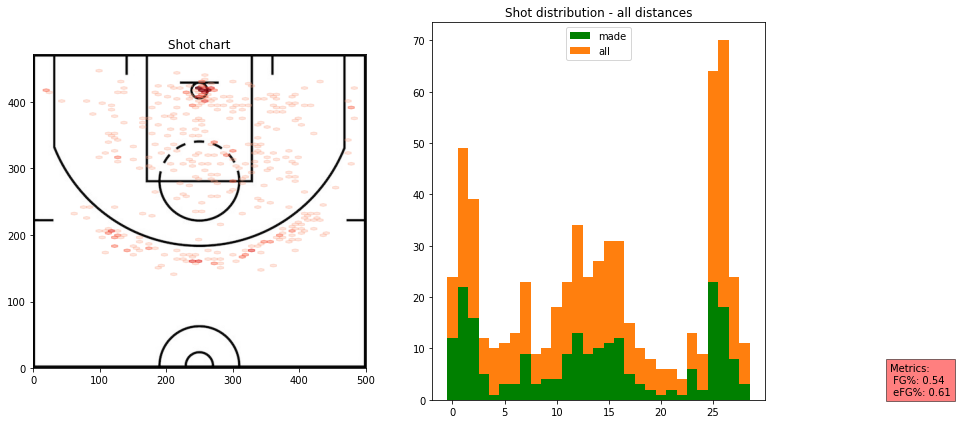

In [65]:
player_shots.plot_shots()

In [66]:
player_shots = PlayerShots(shots_2020,"Russell Westbrook")

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


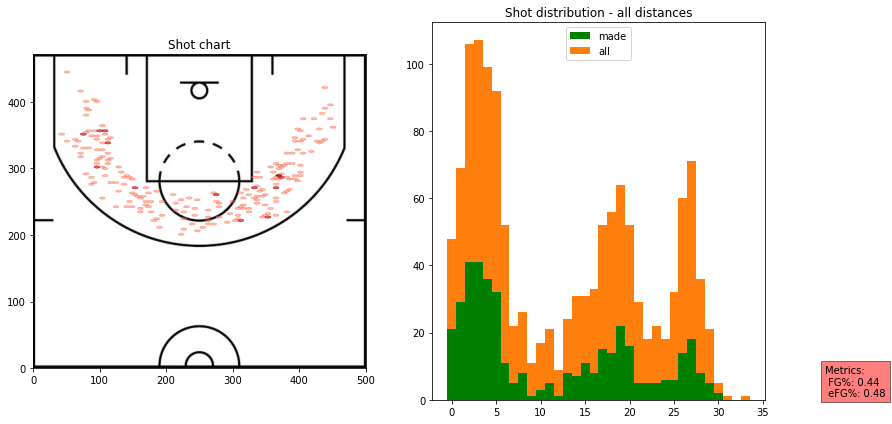

In [67]:
player_shots.plot_shots(distance_limit=(16,26),attempt="2-pointer")

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


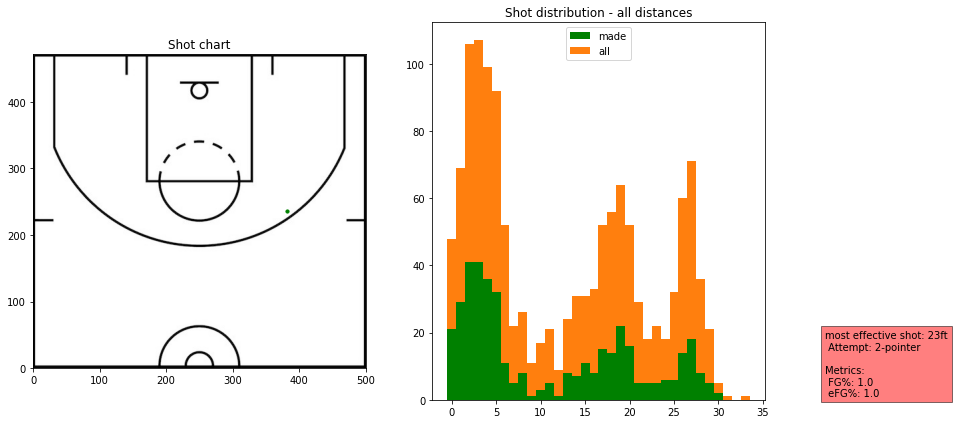

In [68]:
player_shots.plot_effective(metric="efg", exclude=['0ft','22ft',"1ft"])

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


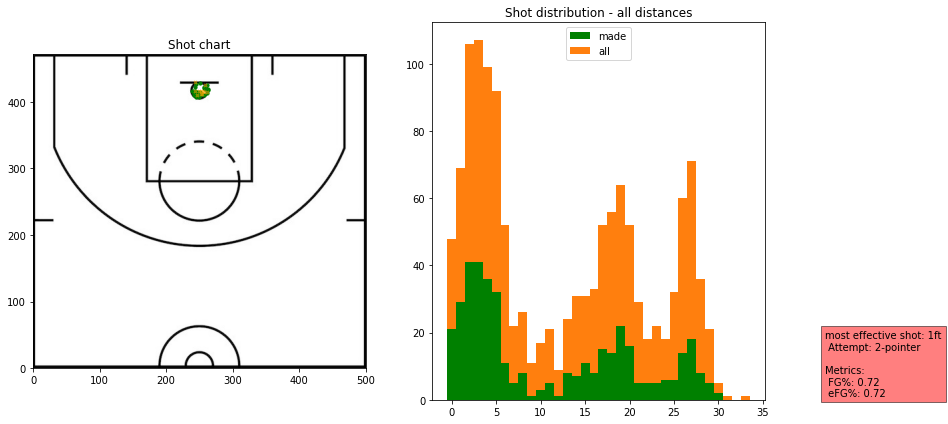

In [69]:
player_shots.plot_effective(metric="efg", min_shots="auto",exclude=['2ft'])

In [70]:
player_shots = PlayerShots(shots_2020,"James Harden")

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


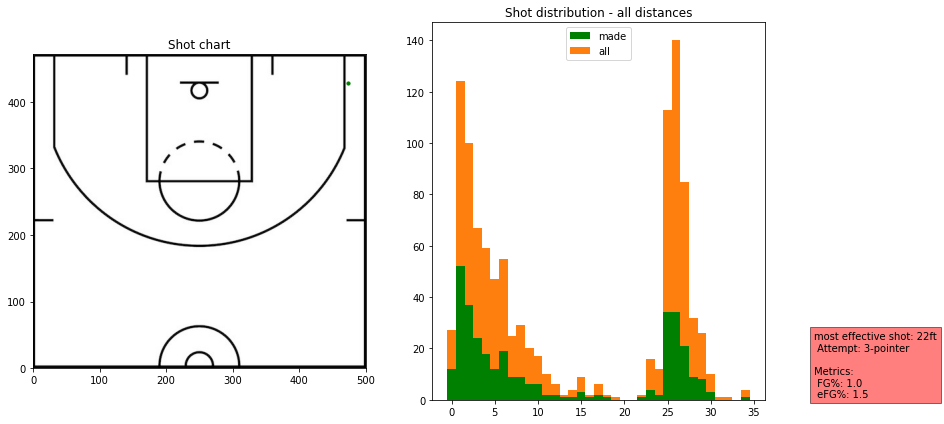

In [71]:
player_shots.plot_effective(metric="efg", exclude=['16ft',"0ft","11ft",'1ft'])

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


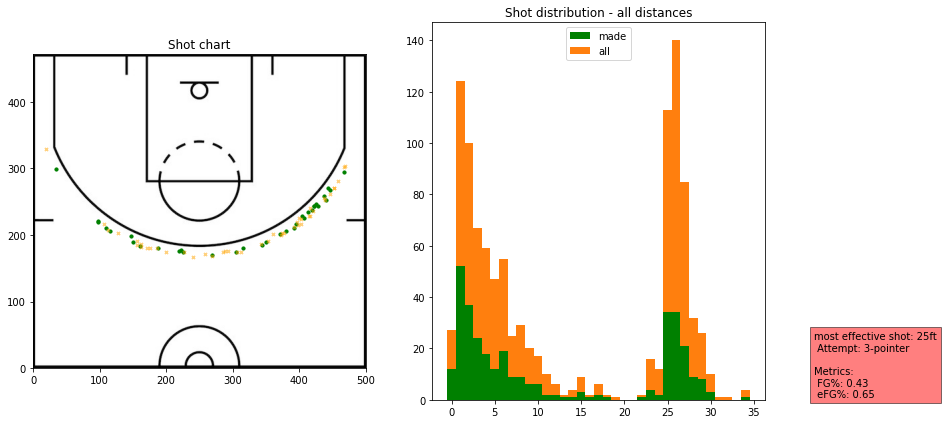

In [72]:
player_shots.plot_effective(min_shots="auto",exclude=['1ft','28ft','2ft','3ft'])

In [73]:
player_shots = PlayerShots(shots_2020, 'Derrick Rose')

In [82]:
player_shots.list_game_ids(2021,4,16)

,game_id,winner,loser
147044,202104160DAL,New York,Dallas


<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


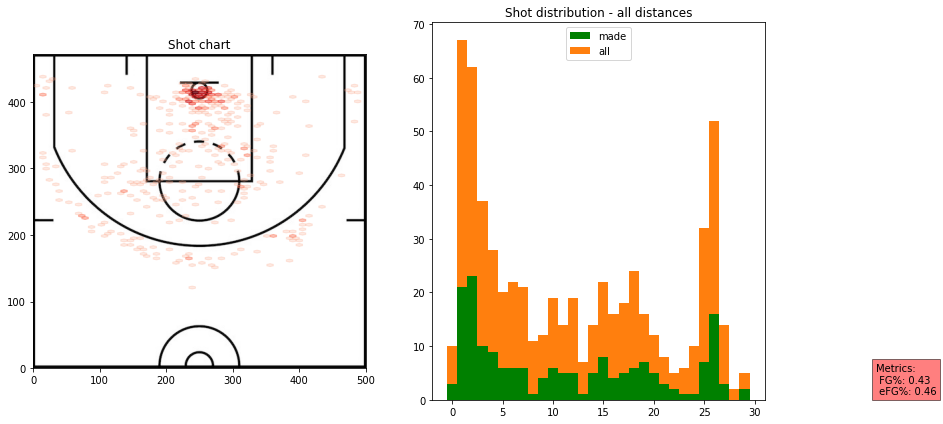

In [83]:
player_shots.plot_shots()

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


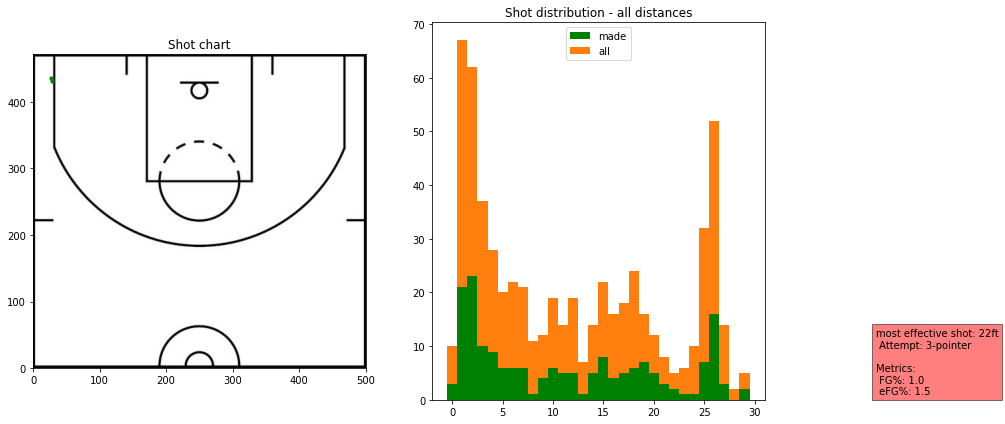

In [84]:
player_shots.plot_effective()

<ipython-input-17-a092ce7bf15d>:42: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``PIL.Image.open(urllib.request.urlopen(url))``.
  img = plt.imread("http://d2p3bygnnzw9w3.cloudfront.net/req/1/images/bbr/nbahalfcourt.png")


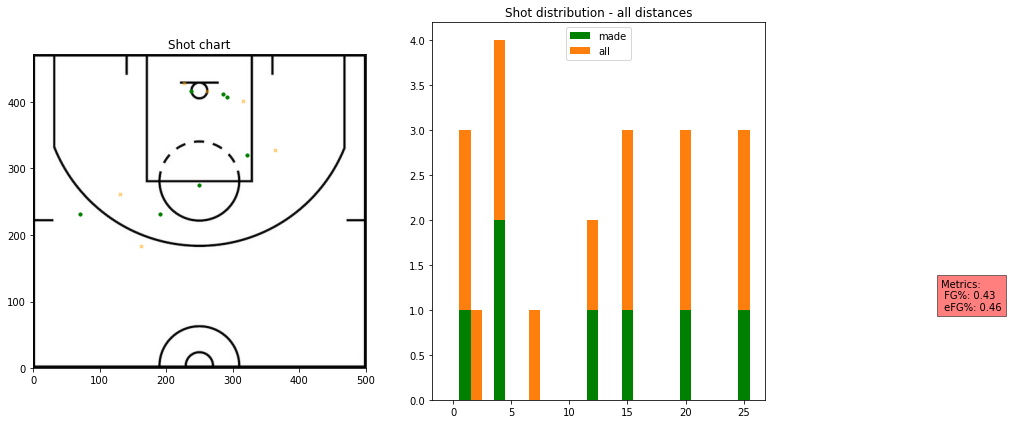

In [85]:
player_shots.plot_shots(date_range='202104160DAL')

## Export -